In [ ]:
  from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/My Drive/prova_NN

/gdrive/My Drive/prova_NN


In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
dataset = pd.read_csv('Training.csv')
print(dataset.shape)
dataset.head(20)

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672
5,7.82592,4.22372,10.11672,1.64906,3.12314,47.010218,3.41862
6,7.52214,4.11250,9.89428,1.58930,3.22440,46.892360,3.24100
7,7.31962,4.00128,9.56062,1.53120,3.12314,45.959439,3.24100
8,7.26982,3.89006,9.56062,1.58930,3.02188,47.126421,3.12314
9,7.26982,4.00128,9.56062,1.70716,2.97208,46.659961,3.24100


In [ ]:
columns = dataset.columns

In [ ]:
val_split = 0.1
val_size = dataset.shape[0]//10

(61676, 7) (6852, 7)


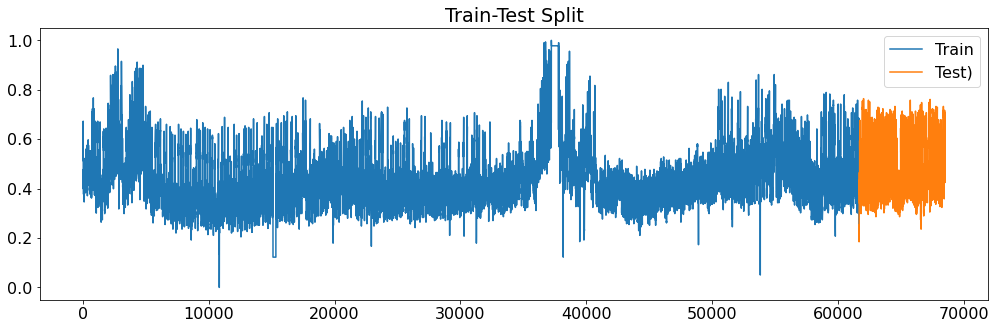

In [ ]:
X_train_raw = dataset.iloc[:-val_size]

X_test_raw = dataset.iloc[-val_size:]

print(X_train_raw.shape, X_test_raw.shape)

# Normalize
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw['Sponginess'], label='Train')
plt.plot(X_test_raw['Sponginess'], label='Test)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [ ]:
window = 200
stride = 10

In [ ]:
future = dataset[-window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
future.shape

(1, 200, 7)

In [ ]:
def build_sequences(df, target_labels=['pollution'], window=200, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [ ]:
target_labels = dataset.columns
telescope = 1

In [ ]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6160, 200, 7), (6160, 1, 7), (680, 200, 7), (680, 1, 7))

In [ ]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

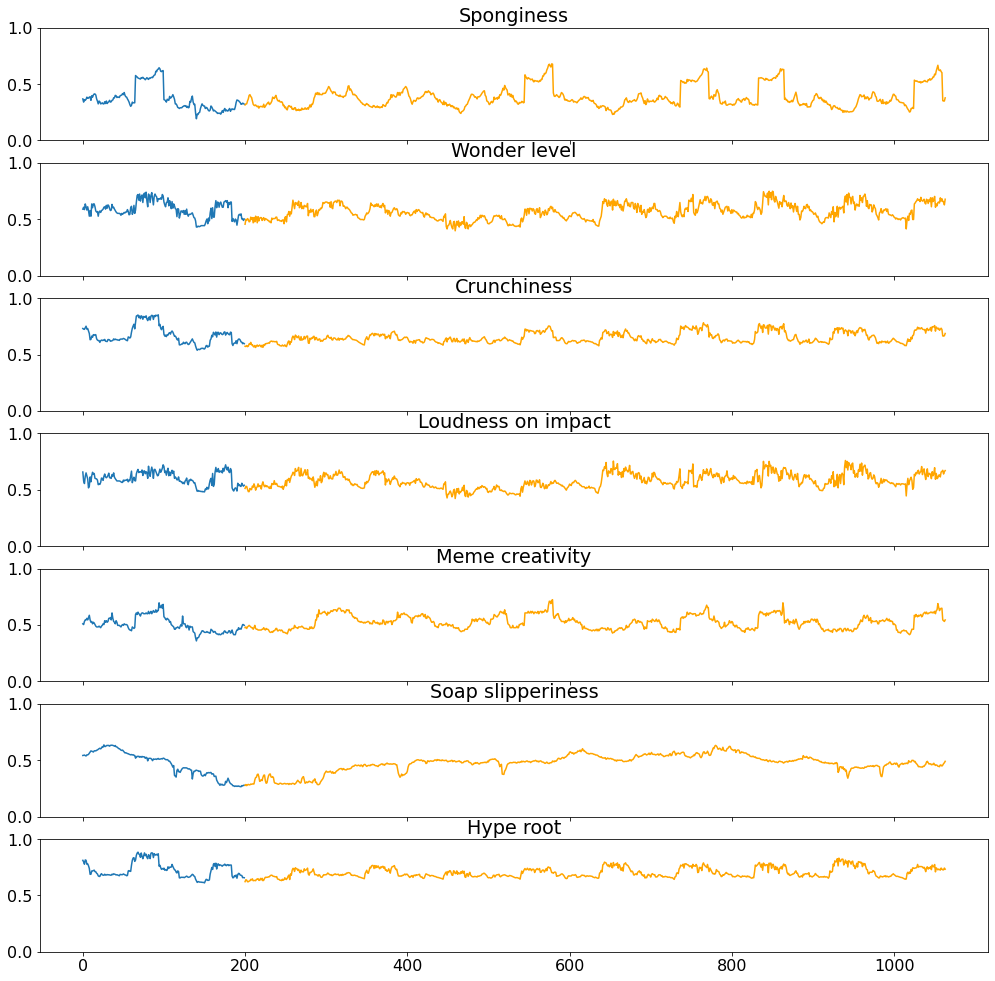

In [ ]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 50

In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    convlstm = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True))(input_layer)
    convlstm = tfkl.Conv1D(128, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)
    convlstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(convlstm)
    convlstm = tfkl.Conv1D(256, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.GlobalAveragePooling1D()(convlstm)
    convlstm = tfkl.Dropout(.5)(convlstm)

    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 200, 7)]          0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 200, 128)         36864     
 nal)                                                            
                                                                 
 conv1d_6 (Conv1D)           (None, 200, 128)          49280     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 100, 128)         0         
 1D)                                                             
                                                                 
 bidirectional_5 (Bidirectio  (None, 100, 256)         263168    
 nal)                                                            
                                                             

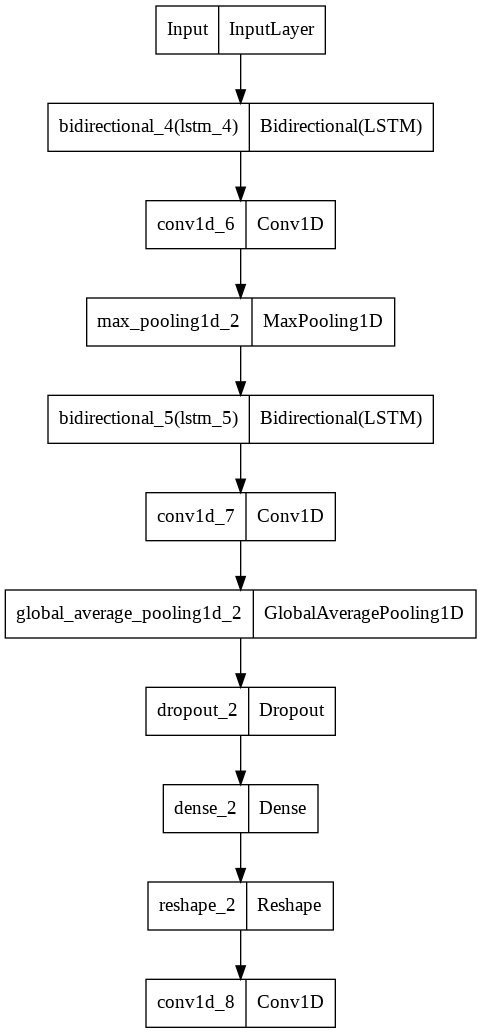

In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
87/87 [==============================] - 25s 204ms/step - loss: 0.1106 - mae: 0.2581 - val_loss: 0.0335 - val_mae: 0.1344 - lr: 0.0010
Epoch 2/200
87/87 [==============================] - 16s 187ms/step - loss: 0.0246 - mae: 0.1216 - val_loss: 0.0174 - val_mae: 0.0908 - lr: 0.0010
Epoch 3/200
87/87 [==============================] - 16s 185ms/step - loss: 0.0179 - mae: 0.1034 - val_loss: 0.0162 - val_mae: 0.0874 - lr: 0.0010
Epoch 4/200
87/87 [==============================] - 16s 188ms/step - loss: 0.0157 - mae: 0.0974 - val_loss: 0.0119 - val_mae: 0.0783 - lr: 0.0010
Epoch 5/200
87/87 [==============================] - 16s 188ms/step - loss: 0.0141 - mae: 0.0923 - val_loss: 0.0116 - val_mae: 0.0763 - lr: 0.0010
Epoch 6/200
87/87 [==============================] - 16s 183ms/step - loss: 0.0130 - mae: 0.0889 - val_loss: 0.0104 - val_mae: 0.0730 - lr: 0.0010
Epoch 7/200
87/87 [==============================] - 16s 185ms/step - loss: 0.0123 - mae: 0.0863 - val_loss: 0.0105 - 

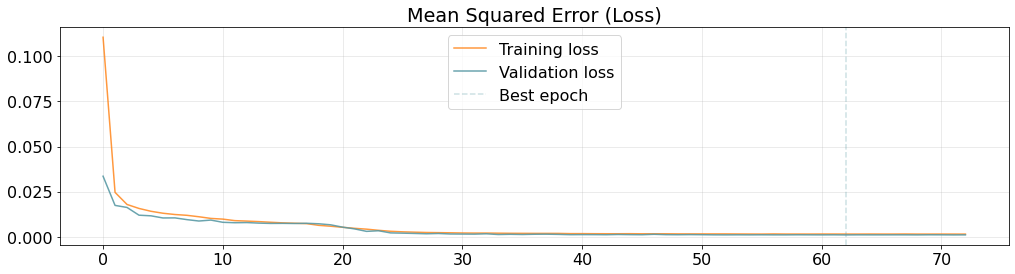

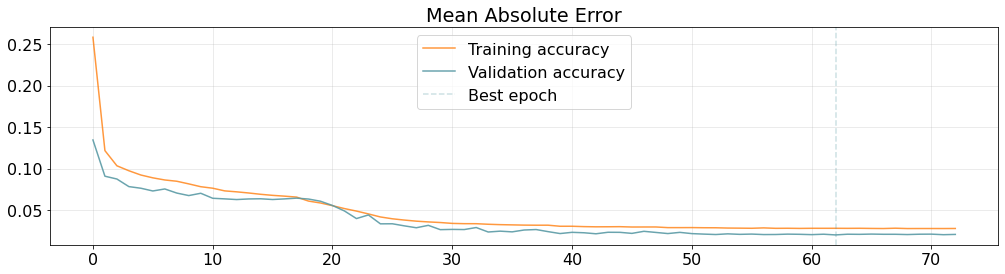

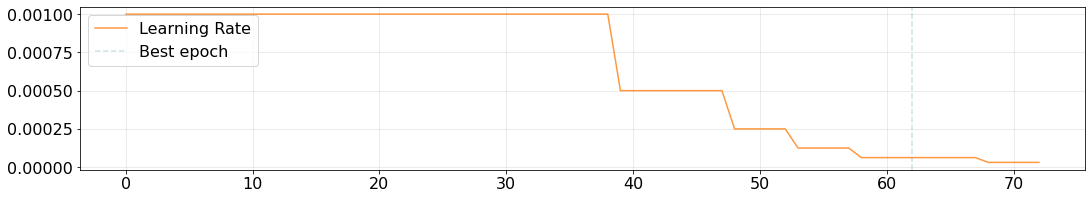

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(680, 1, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.0013154718>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.024249405>)

In [ ]:
reg_telescope = 864
X_test_reg, y_test_reg = build_sequences(X_test_raw, target_labels, window, stride, reg_telescope)
X_test_reg.shape, y_test_reg.shape

((594, 200, 7), (594, 864, 7))

In [ ]:
reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(reg_telescope):
    pred_temp = model.predict(X_temp)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,1:,:],pred_temp), axis=1)

In [ ]:
reg_predictions.shape

(594, 864, 7)

In [ ]:
mean_squared_error = tfk.metrics.mse(y_test_reg.flatten(),reg_predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test_reg.flatten(),reg_predictions.flatten())
mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float32, numpy=0.8090333>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.15171465>)

In [ ]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

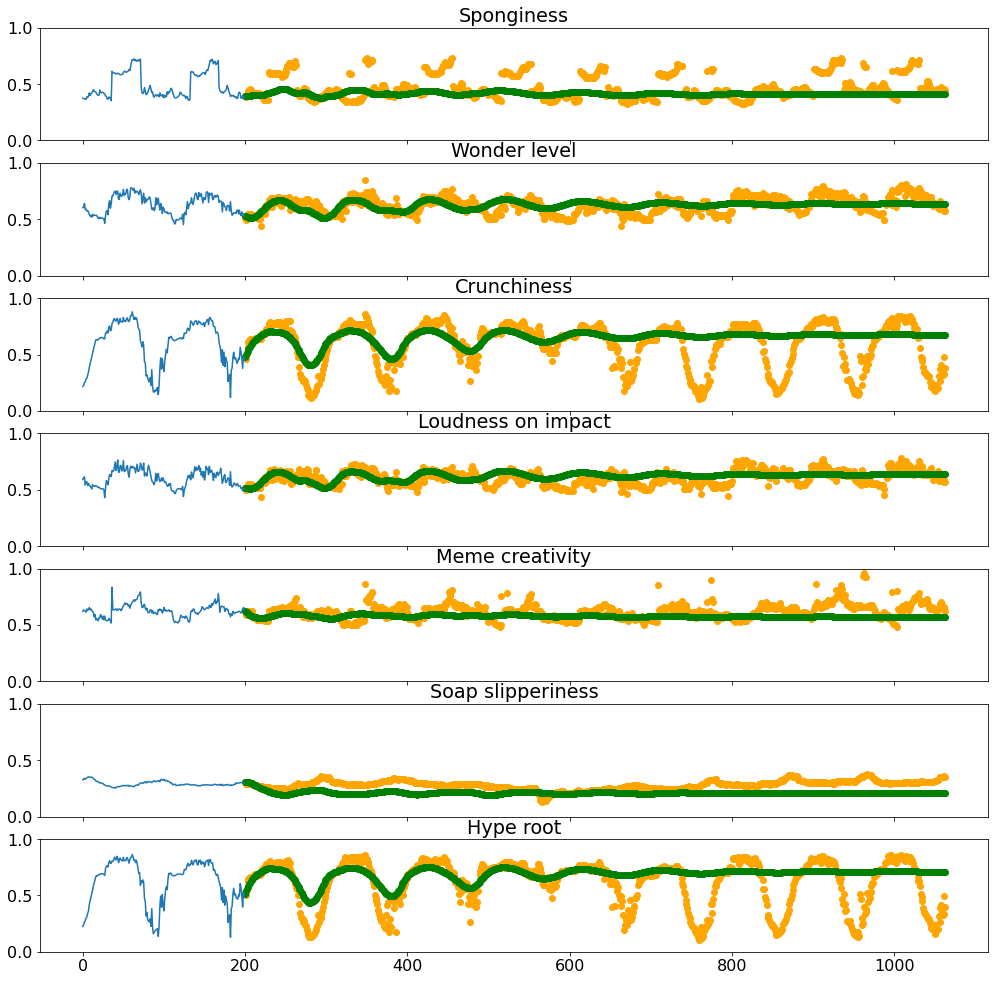

In [ ]:
inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, target_labels, reg_telescope,idx = 592)

In [ ]:
model.save('first_good')

this is learning something with no sine or cosine

i want to enlarge the model and than try with sine and cosine

In [ ]:
def build_CONV_LSTM_model2(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    convlstm = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True))(input_layer)
    convlstm = tfkl.Conv1D(128, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)
    convlstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(convlstm)
    convlstm = tfkl.Conv1D(256, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)
    convlstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(convlstm)
    convlstm = tfkl.Conv1D(256, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.GlobalAveragePooling1D()(convlstm)
    convlstm = tfkl.Dropout(.5)(convlstm)

    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 200, 7)]          0         
                                                                 
 bidirectional_10 (Bidirecti  (None, 200, 128)         36864     
 onal)                                                           
                                                                 
 conv1d_14 (Conv1D)          (None, 200, 128)          49280     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 100, 128)         0         
 1D)                                                             
                                                                 
 bidirectional_11 (Bidirecti  (None, 100, 256)         263168    
 onal)                                                           
                                                             

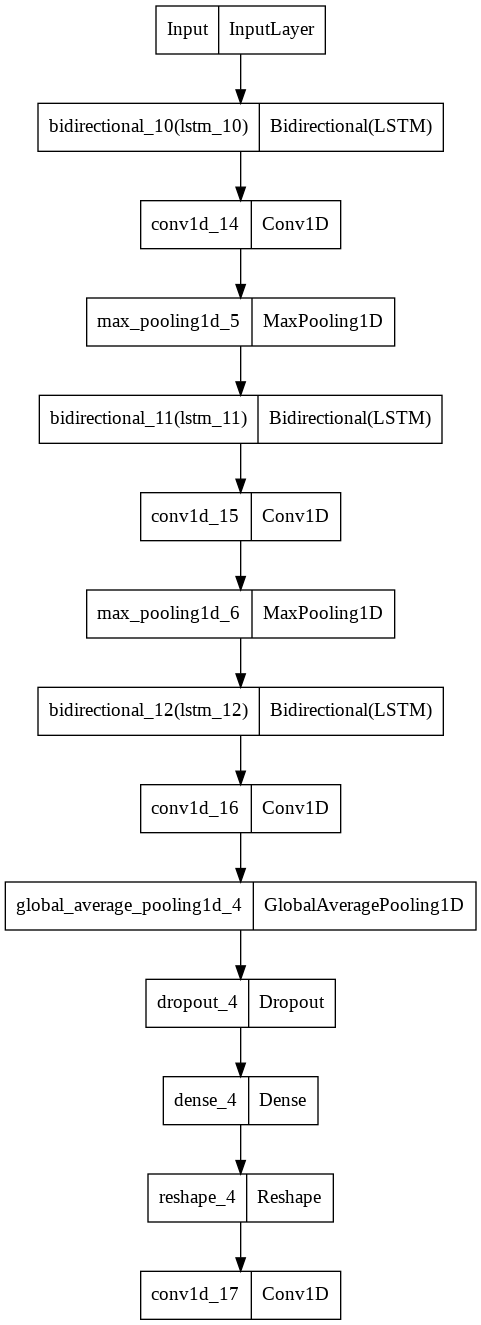

In [ ]:
model = build_CONV_LSTM_model2(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
87/87 [==============================] - 32s 244ms/step - loss: 0.1137 - mae: 0.2674 - val_loss: 0.0244 - val_mae: 0.1237 - lr: 0.0010
Epoch 2/200
87/87 [==============================] - 19s 220ms/step - loss: 0.0232 - mae: 0.1193 - val_loss: 0.0189 - val_mae: 0.1021 - lr: 0.0010
Epoch 3/200
87/87 [==============================] - 18s 212ms/step - loss: 0.0195 - mae: 0.1087 - val_loss: 0.0209 - val_mae: 0.1056 - lr: 0.0010
Epoch 4/200
87/87 [==============================] - 18s 212ms/step - loss: 0.0178 - mae: 0.1037 - val_loss: 0.0190 - val_mae: 0.1063 - lr: 0.0010
Epoch 5/200
87/87 [==============================] - 19s 213ms/step - loss: 0.0167 - mae: 0.1010 - val_loss: 0.0171 - val_mae: 0.0994 - lr: 0.0010
Epoch 6/200
87/87 [==============================] - 19s 213ms/step - loss: 0.0154 - mae: 0.0968 - val_loss: 0.0160 - val_mae: 0.0977 - lr: 0.0010
Epoch 7/200
87/87 [==============================] - 18s 212ms/step - loss: 0.0147 - mae: 0.0947 - val_loss: 0.0151 - 

In [ ]:
model.save('big_model_from_ese')

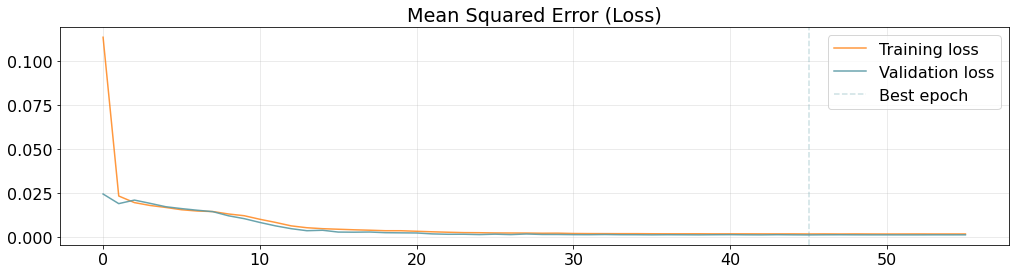

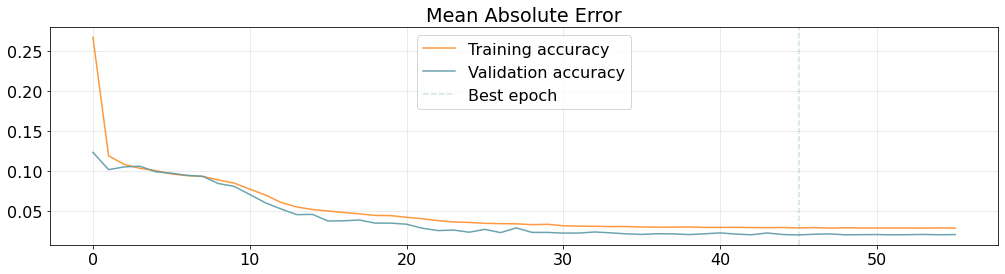

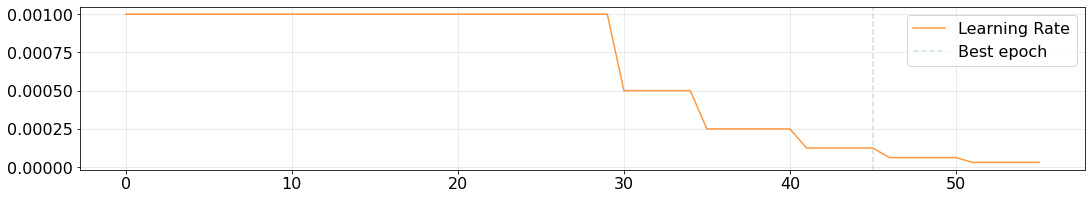

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(680, 1, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.0014320371>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.025326286>)

In [ ]:
reg_telescope = 864
X_test_reg, y_test_reg = build_sequences(X_test_raw, target_labels, window, stride, reg_telescope)
X_test_reg.shape, y_test_reg.shape

((594, 200, 7), (594, 864, 7))

In [ ]:
reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(reg_telescope):
    pred_temp = model.predict(X_temp)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,1:,:],pred_temp), axis=1)

In [ ]:
reg_predictions.shape

(594, 864, 7)

In [ ]:
mean_squared_error = tfk.metrics.mse(y_test_reg.flatten(),reg_predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test_reg.flatten(),reg_predictions.flatten())
mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float32, numpy=0.026053349>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.121520154>)

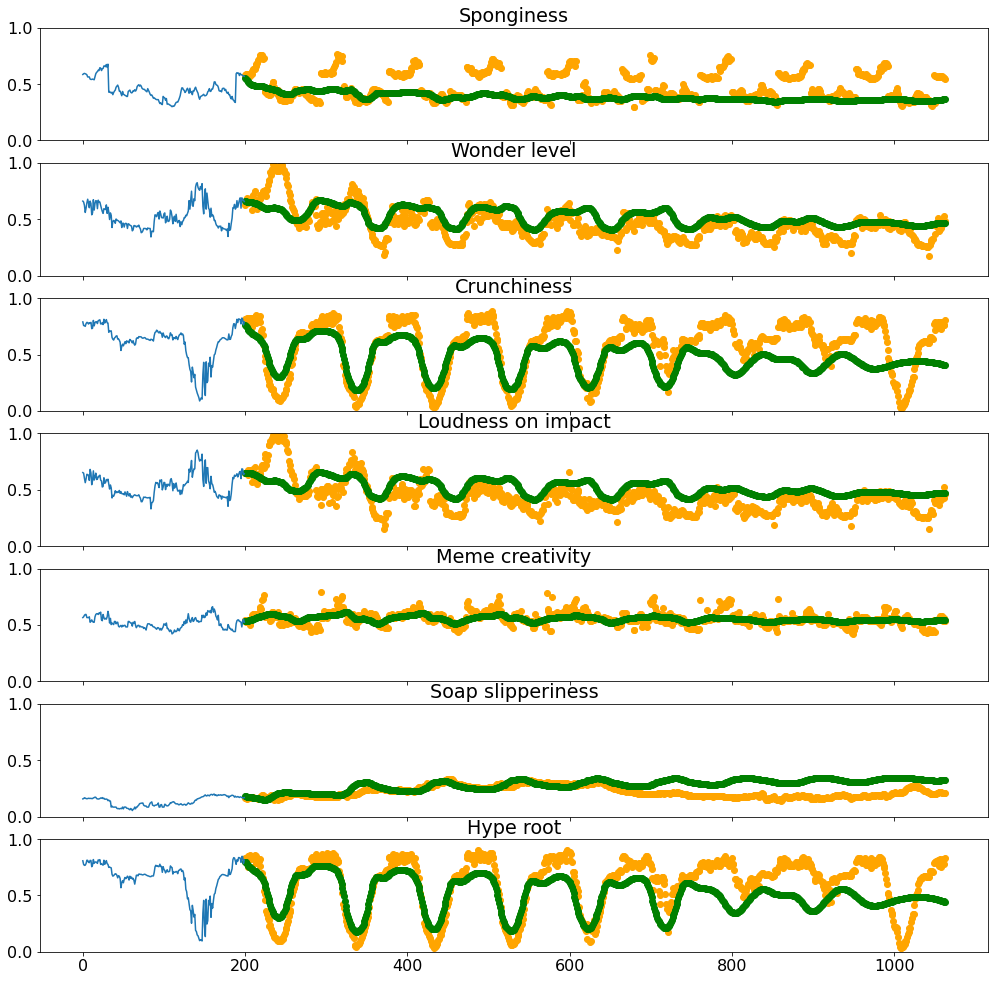

In [ ]:
inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, target_labels, reg_telescope)

enlarging the convolutions in previous model

In [ ]:
def build_CONV_LSTM_model3(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    convlstm = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True))(input_layer)
    convlstm = tfkl.Conv1D(128, 5, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)
    convlstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(convlstm)
    convlstm = tfkl.Conv1D(256, 5, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)
    convlstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(convlstm)
    convlstm = tfkl.Conv1D(256, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.GlobalAveragePooling1D()(convlstm)
    convlstm = tfkl.Dropout(.5)(convlstm)

    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 200, 7)]          0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 200, 128)         36864     
 nal)                                                            
                                                                 
 conv1d_10 (Conv1D)          (None, 200, 128)          82048     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 100, 128)         0         
 1D)                                                             
                                                                 
 bidirectional_9 (Bidirectio  (None, 100, 256)         263168    
 nal)                                                            
                                                             

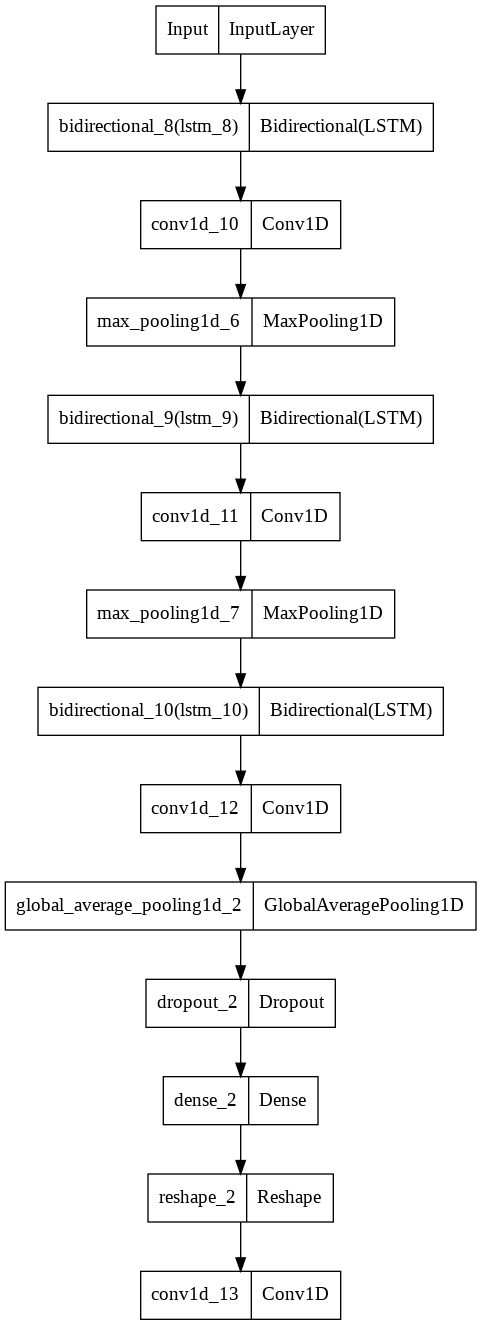

In [ ]:
model = build_CONV_LSTM_model3(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [ ]:
# Train the model
history2 = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
87/87 [==============================] - 33s 244ms/step - loss: 0.1855 - mae: 0.3590 - val_loss: 0.1245 - val_mae: 0.2890 - lr: 0.0010
Epoch 2/200
87/87 [==============================] - 18s 210ms/step - loss: 0.0689 - mae: 0.2094 - val_loss: 0.0382 - val_mae: 0.1623 - lr: 0.0010
Epoch 3/200
87/87 [==============================] - 18s 206ms/step - loss: 0.0223 - mae: 0.1181 - val_loss: 0.0216 - val_mae: 0.1085 - lr: 0.0010
Epoch 4/200
87/87 [==============================] - 18s 205ms/step - loss: 0.0184 - mae: 0.1044 - val_loss: 0.0208 - val_mae: 0.1083 - lr: 0.0010
Epoch 5/200
87/87 [==============================] - 17s 197ms/step - loss: 0.0175 - mae: 0.1022 - val_loss: 0.0205 - val_mae: 0.1088 - lr: 0.0010
Epoch 6/200
87/87 [==============================] - 17s 193ms/step - loss: 0.0170 - mae: 0.1007 - val_loss: 0.0193 - val_mae: 0.1083 - lr: 0.0010
Epoch 7/200
87/87 [==============================] - 17s 190ms/step - loss: 0.0154 - mae: 0.0965 - val_loss: 0.0168 - 

In [ ]:
model.save('bigger_2')

In [ ]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(680, 1, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.0014726768>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.025354944>)

In [ ]:
reg_telescope = 864
X_test_reg, y_test_reg = build_sequences(X_test_raw, target_labels, window, stride, reg_telescope)
X_test_reg.shape, y_test_reg.shape

((594, 200, 7), (594, 864, 7))

In [ ]:
reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(reg_telescope):
    pred_temp = model.predict(X_temp)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,1:,:],pred_temp), axis=1)

In [ ]:
mean_squared_error = tfk.metrics.mse(y_test_reg.flatten(),reg_predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test_reg.flatten(),reg_predictions.flatten())
mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float32, numpy=0.021435065>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.1058651>)

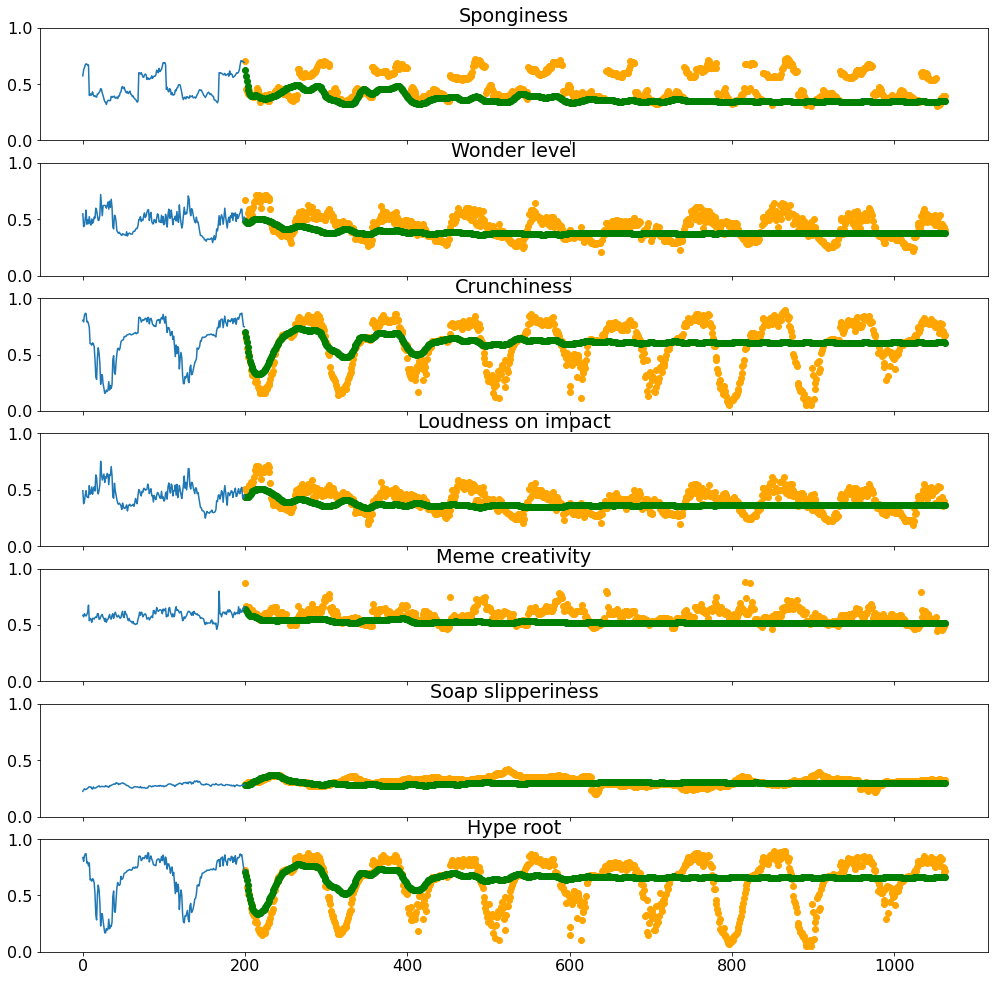

In [ ]:
inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, target_labels, reg_telescope)

this is not working the predictions are still very related to the mean

i want to enlarge the window with a bigger model

In [ ]:
def build_CONV_LSTM_model3(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    convlstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    convlstm = tfkl.Conv1D(64, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)
    convlstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(convlstm)
    convlstm = tfkl.Conv1D(128, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)
    convlstm = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True))(convlstm)
    convlstm = tfkl.Conv1D(256, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)
    convlstm = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True))(convlstm)
    convlstm = tfkl.Conv1D(512, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.GlobalAveragePooling1D()(convlstm)
    convlstm = tfkl.Dropout(.4)(convlstm)

    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 200, 7)]          0         
                                                                 
 bidirectional (Bidirectiona  (None, 200, 256)         139264    
 l)                                                              
                                                                 
 conv1d (Conv1D)             (None, 200, 64)           49216     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 100, 64)          0         
 )                                                               
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 256)         197632    
 nal)                                                            
                                                             

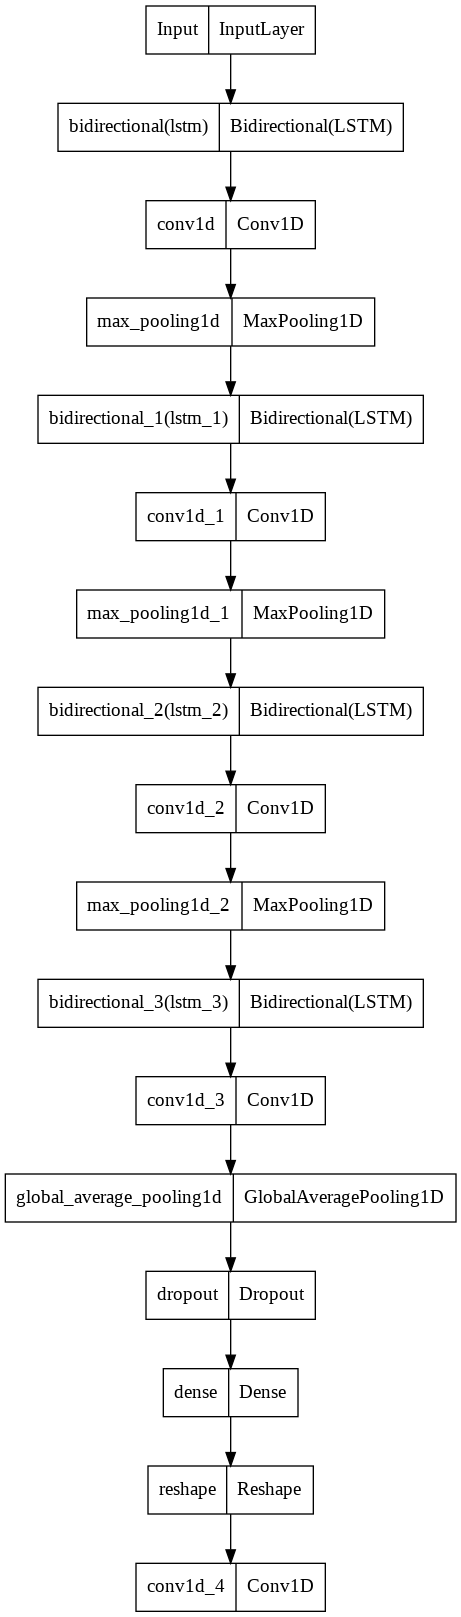

In [ ]:
model = build_CONV_LSTM_model3(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [ ]:
# Train the model
history3 = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/50
87/87 [==============================] - 249s 3s/step - loss: 0.0967 - mae: 0.2431 - val_loss: 0.0568 - val_mae: 0.2007 - lr: 0.0010
Epoch 2/50
87/87 [==============================] - 213s 2s/step - loss: 0.0259 - mae: 0.1231 - val_loss: 0.0217 - val_mae: 0.1067 - lr: 0.0010
Epoch 3/50
87/87 [==============================] - 207s 2s/step - loss: 0.0148 - mae: 0.0927 - val_loss: 0.0144 - val_mae: 0.0859 - lr: 0.0010
Epoch 4/50
87/87 [==============================] - 207s 2s/step - loss: 0.0110 - mae: 0.0813 - val_loss: 0.0093 - val_mae: 0.0709 - lr: 0.0010
Epoch 5/50
87/87 [==============================] - 209s 2s/step - loss: 0.0104 - mae: 0.0786 - val_loss: 0.0085 - val_mae: 0.0680 - lr: 0.0010
Epoch 6/50
87/87 [==============================] - 208s 2s/step - loss: 0.0093 - mae: 0.0741 - val_loss: 0.0086 - val_mae: 0.0691 - lr: 0.0010
Epoch 7/50
87/87 [==============================] - 209s 2s/step - loss: 0.0086 - mae: 0.0712 - val_loss: 0.0094 - val_mae: 0.0747 - lr:

In [ ]:
model.save('bigger3')

In [ ]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(680, 1, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.0017105836>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.029638592>)

In [ ]:
reg_telescope = 864
X_test_reg, y_test_reg = build_sequences(X_test_raw, target_labels, window, stride, reg_telescope)
X_test_reg.shape, y_test_reg.shape

((594, 200, 7), (594, 864, 7))

In [ ]:
reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(reg_telescope):
    pred_temp = model.predict(X_temp)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,1:,:],pred_temp), axis=1)

In [ ]:
mean_squared_error = tfk.metrics.mse(y_test_reg.flatten(),reg_predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test_reg.flatten(),reg_predictions.flatten())
mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float32, numpy=0.029894963>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.12269767>)

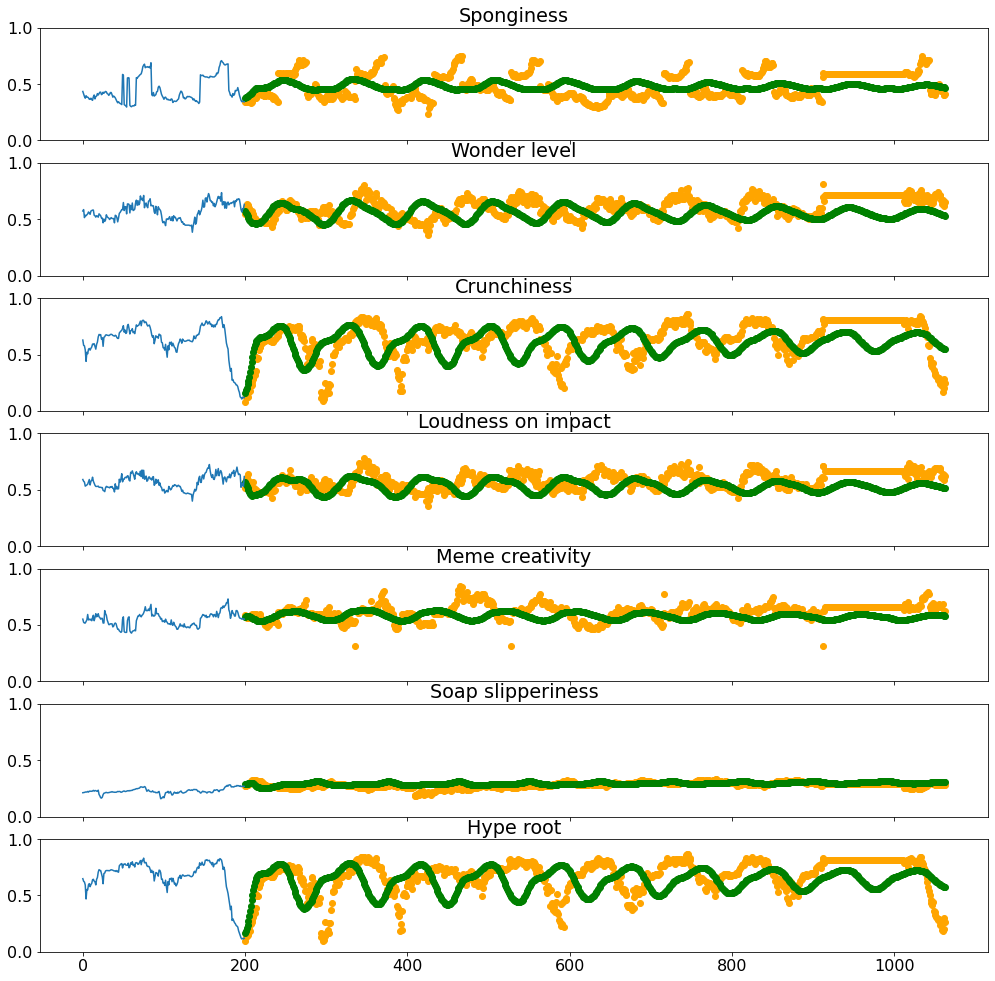

In [ ]:
inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, target_labels, reg_telescope)

my idea is to inject an information about time in the model to capture periodivity, in particular i want to use sine and cosine of the timestamp with a periodicty of 96.

In [ ]:
temp= dataset
temp['index'] = range(dataset.shape[0]) 

In [ ]:
period = 96
temp['sin'] = np.sin(temp['index'] * (2* np.pi / period))
temp['cos'] = np.cos(temp['index'] * (2 * np.pi / period))
del temp['index']
temp.head()

In [ ]:
val_split = 0.1
val_size = temp.shape[0]//10

In [ ]:
X_train_raw = temp.iloc[:-val_size]

X_val_raw = temp.iloc[-val_size:]

print(X_train_raw.shape, X_val_raw.shape)

# Normalize
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_val_raw = (X_val_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw['Sponginess'], label='Train')
plt.plot(X_val_raw['Sponginess'], label='Test)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [ ]:
window = 200
stride = 10

In [ ]:
future = temp[-window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
future.shape

In [ ]:
telescope = 1
target_labels = temp.columns

In [ ]:
def build_sequences2(df, target_labels=['Sponginess'], window=200, stride=20, telescope=1,col = dataset.columns):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[col].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [ ]:
col = dataset.columns

In [ ]:
X_train, y_train = build_sequences2(X_train_raw, target_labels, window, stride, telescope,col)
X_val, y_val = build_sequences2(X_val_raw, target_labels, window, stride, telescope, col)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    convlstm = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True))(input_layer)
    convlstm = tfkl.Conv1D(128, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)
    convlstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(convlstm)
    convlstm = tfkl.Conv1D(256, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.GlobalAveragePooling1D()(convlstm)
    convlstm = tfkl.Dropout(.5)(convlstm)

    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 32
epochs = 20

In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# Predict the test set 
predictions = model.predict(X_val)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_val.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_val.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

In [ ]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

In [ ]:
inspect_multivariate_prediction(X_val, y_val, predictions, col, telescope)

In [ ]:
reg_telescope = 864
X_val_reg, y_val_reg = build_sequences2(X_val_raw, target_labels, window, stride, reg_telescope, col)
X_val_reg.shape, y_val_reg.shape

In [ ]:
X_temp = X_val_reg
next_sin = np.sin(np.arcsin(X_temp[:,-1,7]) + np.sin(2*np.pi/period))

In [ ]:
def find_theta(X_temp):
  prev_sin = X_temp[:,-1,7]
  prev_cos = X_temp[:,-1,8]
  thetas = np.arcsin(prev_sin)
  thetac = np.arccos(prev_cos)
  theta = thetas
  for i in range(len(theta)):
    if(prev_sin[i] >= 0 and prev_cos[i] < 0):
      theta[i] = thetac[i]
    if(prev_sin[i] < 0 and prev_cos[i] < 0):
      theta[i] = -1*thetac[i]
  return theta


In [ ]:
reg_predictions = np.array([])
X_temp = X_val_reg
new_shape = (X_val_reg.shape[0],1,1)
theta = find_theta(X_val_reg)
curr_theta = theta
for reg in range(reg_telescope):
    pred_temp = model.predict(X_temp)
    next_x = pred_temp
    curr_theta = curr_theta + 2*np.pi/period
    next_sin = np.sin(curr_theta)
    next_cos = np.cos(curr_theta)
    next_x = np.concatenate((next_x,np.reshape(next_sin,new_shape)), axis=-1)
    next_x = np.concatenate((next_x,np.reshape(next_cos,new_shape)), axis=-1)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,1:,:],next_x), axis=1)

In [ ]:
reg_predictions.shape

In [ ]:
mean_squared_error = tfk.metrics.mse(y_val_reg.flatten(),reg_predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_val_reg.flatten(),reg_predictions.flatten())
mean_squared_error, mean_absolute_error

In [ ]:
inspect_multivariate_prediction(X_val_reg, y_val_reg, reg_predictions, col, reg_telescope)

this solves the problem of the plateauing of the predictions but it inserts periodicity which is too strict

i try to enlarge the model

In [ ]:
output_shape = (1,7)

In [ ]:
def build_CONV_LSTM_model3(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    convlstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    convlstm = tfkl.Conv1D(64, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)
    convlstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(convlstm)
    convlstm = tfkl.Conv1D(128, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)
    convlstm = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True))(convlstm)
    convlstm = tfkl.Conv1D(256, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)
    convlstm = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True))(convlstm)
    convlstm = tfkl.Conv1D(512, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.GlobalAveragePooling1D()(convlstm)
    convlstm = tfkl.Dropout(.4)(convlstm)

    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

In [ ]:
model = build_CONV_LSTM_model3(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [ ]:
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = 50,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

In [ ]:

predictions = model.predict(X_val)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_val.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_val.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

In [ ]:
inspect_multivariate_prediction(X_val, y_val, predictions, col, telescope)

In [ ]:
reg_telescope = 864
X_val_reg, y_val_reg = build_sequences2(X_val_raw, target_labels, window, stride, reg_telescope, col)
X_val_reg.shape, y_val_reg.shape

In [ ]:
reg_predictions = np.array([])
X_temp = X_val_reg
new_shape = (X_val_reg.shape[0],1,1)
theta = find_theta(X_val_reg)
curr_theta = theta
for reg in range(reg_telescope):
    pred_temp = model.predict(X_temp)
    next_x = pred_temp
    curr_theta = curr_theta + 2*np.pi/period
    next_sin = np.sin(curr_theta)
    next_cos = np.cos(curr_theta)
    next_x = np.concatenate((next_x,np.reshape(next_sin,new_shape)), axis=-1)
    next_x = np.concatenate((next_x,np.reshape(next_cos,new_shape)), axis=-1)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,1:,:],next_x), axis=1)

In [ ]:
mean_squared_error = tfk.metrics.mse(y_val_reg.flatten(),reg_predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_val_reg.flatten(),reg_predictions.flatten())
mean_squared_error, mean_absolute_error

In [ ]:
inspect_multivariate_prediction(X_val_reg, y_val_reg, reg_predictions, col, reg_telescope)  

it is learning better but the seasonality is still too strong

I want to try with a method which is not autoregressive but has telescope 96 and no sine and cosine added

In [ ]:
dataset = pd.read_csv('Training.csv')
print(dataset.shape)
dataset.head(20)

In [ ]:
X_train_raw = dataset.iloc[:-val_size]

X_val_raw = dataset.iloc[-val_size:]

print(X_train_raw.shape, X_val_raw.shape)

# Normalize
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_val_raw = (X_val_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw['Sponginess'], label='Train')
plt.plot(X_val_raw['Sponginess'], label='Test)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [ ]:
window = 200
stride = 10
telescope = 96

In [ ]:
def build_sequences(df, target_labels, window=200, stride=20, telescope=1):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [ ]:
col = dataset.columns

In [ ]:
X_train, y_train = build_sequences2(X_train_raw, target_labels, window, stride, telescope,col)
X_val, y_val = build_sequences2(X_val_raw, target_labels, window, stride, telescope,col)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    convlstm = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True))(input_layer)
    convlstm = tfkl.Conv1D(128, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)
    convlstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(convlstm)
    convlstm = tfkl.Conv1D(256, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.GlobalAveragePooling1D()(convlstm)
    convlstm = tfkl.Dropout(.5)(convlstm)

    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

In [ ]:
# Predict the test set 
predictions = model.predict(X_val)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_val.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_val.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

In [ ]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

In [ ]:
inspect_multivariate_prediction(X_val, y_val, predictions, col, telescope)

this is promising but needs a bigger network

In [ ]:
def build_sequences(df, target_labels=['Sponginess'], window=200, stride=20, telescope=1):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[columns].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [ ]:
window = 200
stride = 10
telescope = 96
target_labels = dataset.columns

In [ ]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_val, y_val = build_sequences(X_val_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 50

In [ ]:
def build_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    convlstm = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True))(input_layer)
    convlstm = tfkl.Conv1D(128, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)
    convlstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(convlstm)
    convlstm = tfkl.Conv1D(256, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)
    convlstm = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True))(convlstm)
    convlstm = tfkl.Conv1D(512, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.GlobalAveragePooling1D()(convlstm)
    convlstm = tfkl.Dropout(.4)(convlstm)

    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

In [ ]:
model = build_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [ ]:
# Train the model
history2 = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

In [ ]:
# Predict the test set 
predictions = model.predict(X_val)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_val.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_val.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

In [ ]:
def inspect_multivariate_prediction2(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

In [ ]:
inspect_multivariate_prediction2(X_val, y_val, predictions, columns, telescope)

Thise results are more promising even without the sine and cosine